In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [57]:
data = pd.read_csv("all_daily_max_temp.csv")  # Replace with your file name
features = ['elevation', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'dewpoint_c', 'feel_c']
target = 'temp_c'
data=data.drop(columns=['Unnamed: 0','is_hot_day'])
data

,elevation,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c
0,74,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000
1,74,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889
2,74,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000
3,74,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000
4,74,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000
...,...,...,...,...,...,...,...,...,...
5402,74,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444
5403,74,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444
5404,74,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889
5405,74,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333


In [58]:
import numpy as np

# Alternative function to create sequences using sliding windows
def create_sequences_alternative(data, target_col, window_size, prediction_horizon):
    X, y = [], []
    
    # Iterate over the dataset using a sliding window
    for i in range(len(data) - window_size - prediction_horizon + 1):
        # Extract the feature values for the past 'window_size' time steps
        X_seq = data.iloc[i:i + window_size][features].values
        
        # Extract the target values for the next 'prediction_horizon' time steps
        y_seq = data.iloc[i + window_size:i + window_size + prediction_horizon][target_col].values
        
        # Append the sequences to the list
        X.append(X_seq)
        y.append(y_seq)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Parameters
window_size = 3  # Number of timesteps to look at for each sequence
prediction_horizon = 1  # Predict the next 3 days

# Create input-output pairs using the alternative method
X,y= create_sequences_alternative(data, target, window_size, prediction_horizon)

# Display the shapes of the data to check
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"X train ,test shape: {X_train.shape, X_test.shape}")
print(f"y train ,test shape: {y_train.shape, y_test.shape}")


X shape: (5404, 3, 8)
y shape: (5404, 1)
X train ,test shape: ((4323, 3, 8), (1081, 3, 8))
y train ,test shape: ((4323, 1), (1081, 1))


In [59]:
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score

model = load_model('1 day prediction woa-cnn-att-lstm.keras')

y_pred = model.predict(X_test)

# Compute R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R²: 0.8769331110535677


In [60]:
# Evaluate the model on training data
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Print the results
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Train Loss: 6.5804, Train MAE: 1.8851
Test Loss: 5.6151, Test MAE: 1.7974


In [61]:
next_temp = model.predict(X_test[-1].reshape(1, window_size, len(features)))
print(f"Predicted Next Temperature: {next_temp}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Next Temperature: [[27.657907]]


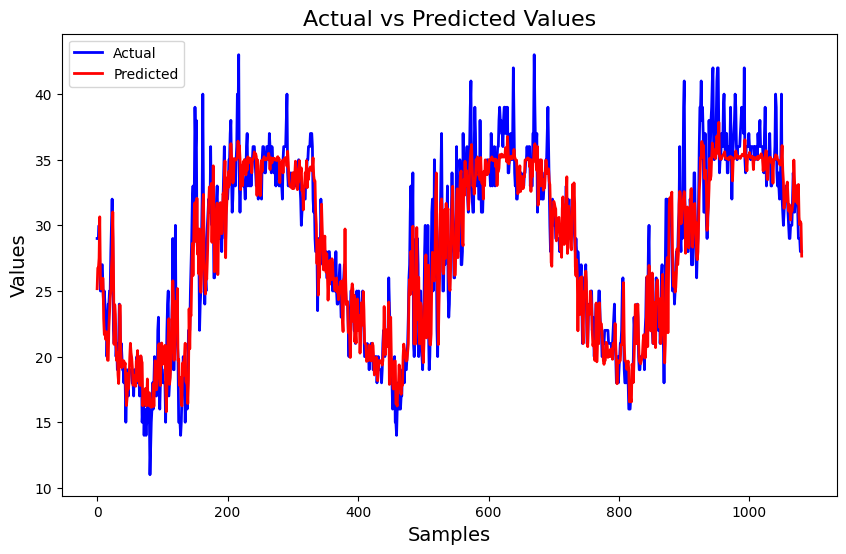

In [62]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(y_pred, label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [63]:
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score

lstm_model = load_model('1 day prediction lstm.keras')

lstm_y_pred = lstm_model.predict(X_test)

# Compute R²
r2 = r2_score(y_test, lstm_y_pred)
print(f"R²: {r2}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R²: 0.8660261751499848


In [64]:
# Predict the next temperature using LSTM
next_temp_lstm = lstm_model.predict(X_test[-1].reshape(1, window_size, len(features)))
print(f"LSTM Predicted Next Temperature: {next_temp_lstm} °C")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM Predicted Next Temperature: [[28.44257]] °C


In [65]:
# Evaluate both models
lstm_train_loss, lstm_train_mae = lstm_model.evaluate(X_train, y_train, verbose=0)
lstm_test_loss, lstm_test_mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {lstm_train_loss:.4f}, Train MAE: {lstm_train_mae:.4f}")
print(f"Test Loss: {lstm_test_loss:.4f}, Test MAE: {lstm_test_mae:.4f}")

Train Loss: 6.8678, Train MAE: 1.9277
Test Loss: 6.1127, Test MAE: 1.8925


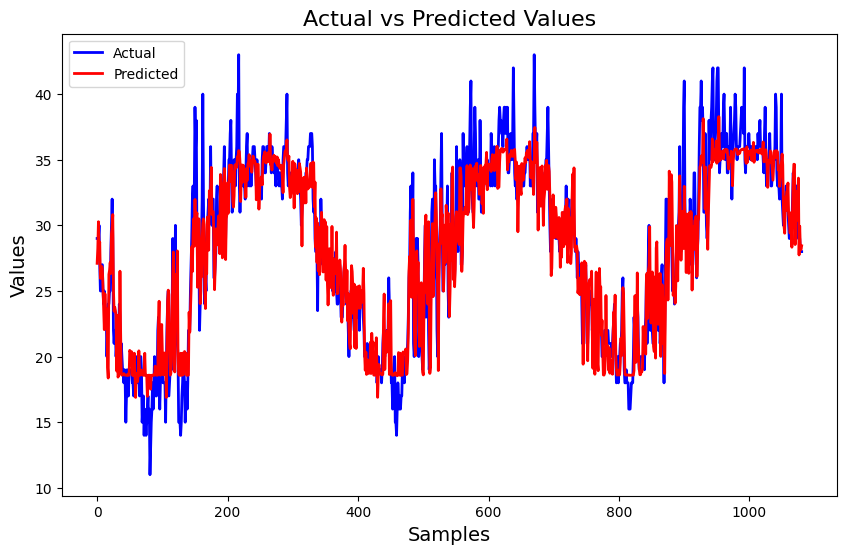

In [66]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(lstm_y_pred, label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Adding a legend
plt.legend()

# Display the plot
plt.show()